In [1]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:
path = 'lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


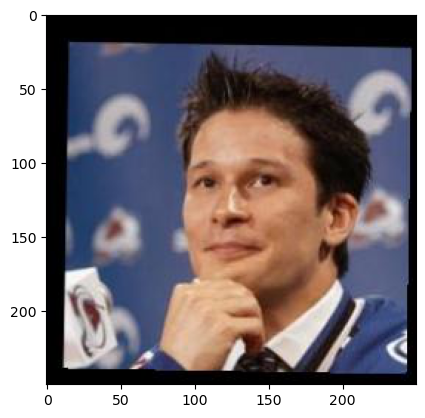

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [8]:
# Get one batch of data
for images, _ in dataloader:
    # We just need the first batch to demonstrate, so we break the loop
    break

# Print the dimensions of the images
print(f"Dimensions of the images: {images.shape}")

# Explain each dimension
print("\nExplanation of each dimension:")
print(f"1. Batch Size: {images.shape[0]} - The number of images in the batch.")
print(f"2. Color Channels: {images.shape[1]} - The number of color channels in the image (e.g., 3 for RGB).")
print(f"3. Height: {images.shape[2]} - The height of the images in pixels.")
print(f"4. Width: {images.shape[3]} - The width of the images in pixels.")


Dimensions of the images: torch.Size([32, 3, 250, 250])

Explanation of each dimension:
1. Batch Size: 32 - The number of images in the batch.
2. Color Channels: 3 - The number of color channels in the image (e.g., 3 for RGB).
3. Height: 250 - The height of the images in pixels.
4. Width: 250 - The width of the images in pixels.


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [9]:
class AE(nn.Module):

    def __init__(self):
        super(AE,self).__init__()
        # Encoder layers
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_bn1 = nn.BatchNorm2d(num_features=64)
        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_bn2 = nn.BatchNorm2d(num_features=128)
        # Decoder layers
        self.dec_convtrans1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.dec_bn1 = nn.BatchNorm2d(num_features=64)
        self.dec_convtrans2 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=2, stride=2)
        self.dec_bn2 = nn.BatchNorm2d(num_features=3)

    def encoder(self,x):
      x = self.enc_conv1(x)
      x = F.relu(x)
      x = self.enc_pool1(x)
      x = self.enc_bn1(x)
      x = self.enc_conv2(x)
      x = F.relu(x)
      x = self.enc_pool2(x)
      x = self.enc_bn2(x)
      return x

    def decoder(self, x):
        x = self.dec_convtrans1(x)  # Transpose conv layer to upsample
        x = F.relu(x)
        x = self.dec_bn1(x)
        x = self.dec_convtrans2(x)  # Another transpose conv layer to upsample
        x = F.relu(x)
        x = self.dec_bn2(x)
        x = F.interpolate(x, size=(256, 256), mode='nearest')
        return x

    def forward(self,x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [10]:
model = AE()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Get a sample image from the dataloader
sample_images, _ = next(iter(dataloader))
sample_image = sample_images[0].unsqueeze(0)  # Add a batch dimension

# Move the sample image to the device
sample_image = sample_image.to(device)

In [12]:
import torch.nn.functional as F
from torchvision.transforms import Resize
from torchvision.transforms.functional import to_pil_image, to_tensor

# Define the transformation
resize_transform = Resize((256, 256))

# Apply the transformation to the sample image
resized_sample_image = resize_transform(to_pil_image(sample_image.squeeze(0)))  # Remove batch dim for resizing
resized_sample_image = to_tensor(resized_sample_image).unsqueeze(0)  # Convert back to tensor and add batch dim

# Verify the size of the resized image
print(f"Shape of the resized input image: {resized_sample_image.shape}")

# Pass the resized image through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # We don't need to calculate gradients here
    final_output = model(resized_sample_image.to(device))

# Print the shape of the final output
print(f"Shape of the final output: {final_output.shape}")

assert final_output.shape == resized_sample_image.shape, "Output shape does not match input shape."

Shape of the resized input image: torch.Size([1, 3, 256, 256])
Shape of the final output: torch.Size([1, 3, 256, 256])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [13]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 109769


In [14]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

In [15]:
loss_function = nn.MSELoss()  

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [16]:
import torch
from torchvision import transforms
from torch import nn, optim

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AE().to(device)
model.train()

# Define the number of epochs
num_epochs = 10

# Define the resize and normalization transforms
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0

    for data in dataloader:
        inputs, _ = data
        inputs = inputs.to(device)

        # Apply the resizing and normalization transforms
        resized_inputs = torch.stack([resize_transform(i) for i in inputs])

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(resized_inputs)

        # Calculate the loss
        loss = loss_function(outputs, resized_inputs)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Add the loss to the total epoch loss (scaled by batch size)
        epoch_loss += loss.item() * inputs.size(0)

    # Calculate the average loss over the dataset
    epoch_loss /= len(dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Save the model after training
torch.save(model.state_dict(), 'autoencoder_model.pth')

Epoch 1/10, Loss: 0.1542
Epoch 2/10, Loss: 0.0243
Epoch 3/10, Loss: 0.0184
Epoch 4/10, Loss: 0.0156
Epoch 5/10, Loss: 0.0154
Epoch 6/10, Loss: 0.0152
Epoch 7/10, Loss: 0.0142
Epoch 8/10, Loss: 0.0151
Epoch 9/10, Loss: 0.0137
Epoch 10/10, Loss: 0.0131


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

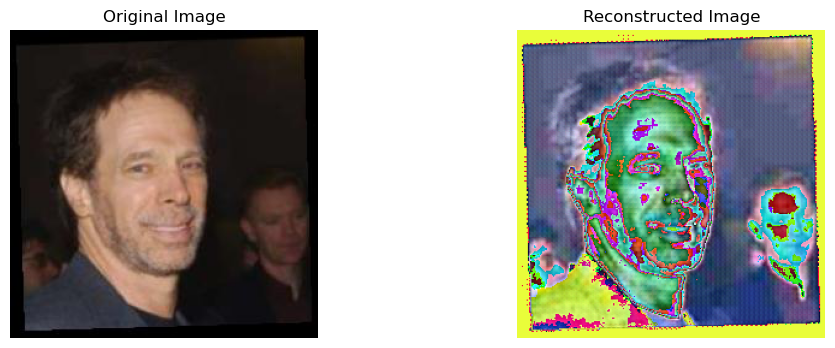

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

model.eval()

dataiter = iter(dataloader)
images, _ = next(dataiter)  

# Select a single random image
idx = np.random.randint(0, len(images))
original_image = images[idx]

transformed_image = resize_transform(original_image)

input_image = transformed_image.unsqueeze(0).to(device)
with torch.no_grad():
    output_image = model(input_image)

output_image = output_image.squeeze(0)

# Convert tensors to PIL images for display
original_image_pil = TF.to_pil_image(original_image)
output_image_pil = TF.to_pil_image(output_image.cpu())

# Plot the original and reconstructed images
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(original_image_pil)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(output_image_pil)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.show()  

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

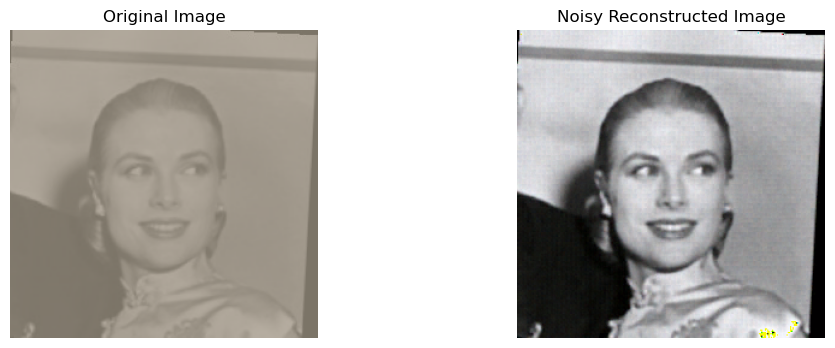

In [37]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.eval()

# Define the resize and normalization transforms
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to denormalize a tensor
def denormalize(tensor, means, stds):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, means, stds):
        t.mul_(s).add_(m)  # The underscore indicates in-place operations
    return tensor

# Define standard deviation for noise
noise_std = 0.1

dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select a single random image
idx = np.random.randint(0, len(images))
original_image = images[idx]

# Normalize and resize the selected image
transformed_image = resize_transform(original_image)

# Add batch dimension and pass the image through the encoder part of the model
input_image = transformed_image.unsqueeze(0).to(device)
with torch.no_grad():
    latent_representation = model.encoder(input_image)

# Add Gaussian noise to the latent representation
noise = torch.randn_like(latent_representation) * noise_std
noisy_latent_representation = latent_representation + noise

# Pass the noisy latent representation through the decoder
with torch.no_grad():
    output_image = model.decoder(noisy_latent_representation)

# Remove batch dimension and perform any necessary post-processing
output_image = output_image.squeeze(0)

# Denormalize the output image
output_image = denormalize(output_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Convert tensors to PIL images for display
original_image_pil = TF.to_pil_image(denormalize(original_image.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
output_image_pil = TF.to_pil_image(output_image.cpu())

# Plot the original and reconstructed images
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(original_image_pil)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(output_image_pil)
axes[1].set_title('Noisy Reconstructed Image')
axes[1].axis('off')

plt.show()